In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.io as sio
from datetime import datetime
from datetime import datetime, timedelta

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules")
from utils import plot_ellipse, espra, smooth, tilt_distance_LI, robust_smooth


#### SADCP Data

In [2]:
sadcp_data = sio.loadmat('/srv/scratch/z5297792/IN2023/sadcp.mat', simplify_cells=True)

z_sadcp = sadcp_data['z_sadcp']
u_sadcp = pd.DataFrame(sadcp_data['u_sadcp'], index=['u_' + str(z) for z in z_sadcp]).T
v_sadcp = pd.DataFrame(sadcp_data['v_sadcp'], index=['v_' + str(z) for z in z_sadcp]).T
lat_sadcp = sadcp_data['lat_sadcp']
lon_sadcp = sadcp_data['lon_sadcp']
tim_sadcp = sadcp_data['tim_sadcp']
julian_dates = tim_sadcp
ref_date = datetime(2000, 1, 1, 12)  # Julian day 2451545.0
gregorian_dates = [ref_date + timedelta(days=jd - 2451545.0) for jd in julian_dates]
tim_sadcp = gregorian_dates

df_sadcp = pd.DataFrame({'Time': tim_sadcp, 'Lon': lon_sadcp, 'Lat': lat_sadcp})
df_sadcp = pd.concat([df_sadcp, u_sadcp, v_sadcp], axis=1)

df_sadcp = df_sadcp[df_sadcp['Lat'] <= -37]
df_sadcp = df_sadcp.reset_index().drop(columns=['index'])

theta_mean, phi_mean = np.float64(154.3), np.float64(-37.9)
df_sadcp['x'] = (df_sadcp.Lon - theta_mean) * 111000 * np.cos(np.deg2rad(phi_mean))
df_sadcp['y'] = (df_sadcp.Lat - phi_mean) * 111000

df_sadcp


,Time,Lon,Lat,u_27,u_37,u_47,u_57,u_67,u_77,u_87,...,v_737,v_747,v_757,v_767,v_777,v_787,v_797,v_807,x,y
0,2023-10-17 10:27:31.000004,154.357059,-37.005208,NaN,0.534412,0.569007,0.549270,0.465635,0.374654,0.323217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4997.725425,99321.875000
1,2023-10-17 10:42:30.333327,154.360804,-37.038123,NaN,0.533096,0.555601,0.561888,0.484809,0.402146,0.357385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5325.695073,95668.330556
2,2023-10-17 10:57:30.666685,154.364625,-37.071899,NaN,0.431565,0.456292,0.483472,0.458337,0.434674,0.398060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5660.396047,91919.202778
3,2023-10-17 11:12:30.333340,154.368274,-37.101418,NaN,0.368063,0.378524,0.410269,0.398222,0.362505,0.358032,...,0.043708,0.042462,NaN,NaN,NaN,NaN,NaN,NaN,5980.012364,88642.647222
4,2023-10-17 11:27:30.666659,154.372221,-37.104340,NaN,0.357789,0.368125,0.399916,0.385093,0.353109,0.356878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6325.742980,88318.280556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2023-10-21 21:27:30.333314,154.179344,-37.150309,NaN,0.246921,0.241454,0.244281,0.212926,0.202732,0.233854,...,0.080013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10568.100129,83215.672222
429,2023-10-21 21:42:30.666672,154.179347,-37.119931,NaN,0.222701,0.196322,0.206364,0.223129,0.236286,0.265476,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.775728,86587.708333
430,2023-10-21 21:57:30.333327,154.179332,-37.088953,NaN,0.214721,0.206698,0.228885,0.243320,0.250907,0.249915,...,0.085535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10569.073333,90026.241667
431,2023-10-21 22:12:30.333314,154.179352,-37.058304,NaN,0.219740,0.226015,0.243559,0.245731,0.227310,0.231003,...,0.077085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10567.370226,93428.288889


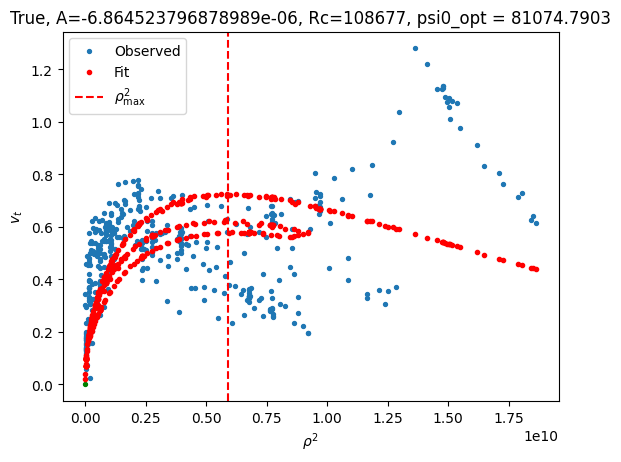

(np.float64(-150000.0),
 np.float64(150000.0),
 np.float64(-150000.0),
 np.float64(150000.0))

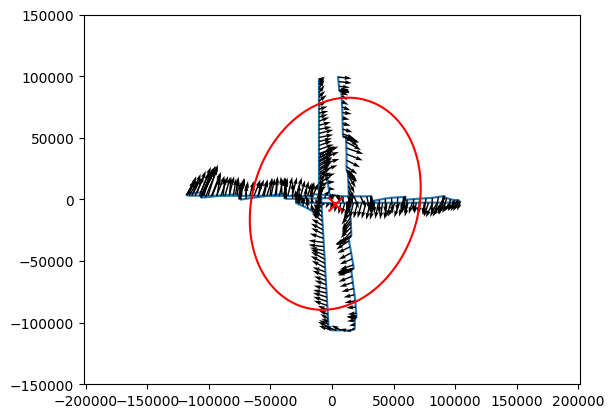

In [3]:
x = np.linspace(-150000, 150000, 101)
y = np.linspace(-150000, 150000, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

xi, yi, ui, vi = df_sadcp.x,  df_sadcp.y, df_sadcp.u_37, df_sadcp.v_37

xc_0, yc_0, w_0, Q_0, Rc_0, psi0_0, A_0 = espra(xi, yi, ui, vi, plot_flag=True, Rc_max=150000)

plt.plot(df_sadcp.x, df_sadcp.y)
plt.quiver(xi, yi, ui, vi, zorder=2)
plt.scatter(xc_0, yc_0, marker='x', s=100, color='r', zorder=3)

dx_ell, dy_ell = X - xc_0, Y - yc_0
rho2_ell = Q_0[0,0]*dx_ell**2 + 2*Q_0[1,0]*dx_ell*dy_ell + Q_0[1,1]*dy_ell**2
plt.contour(X, Y, rho2_ell, levels=[Rc_0**2/2],
            colors='r')

plt.axis('equal')


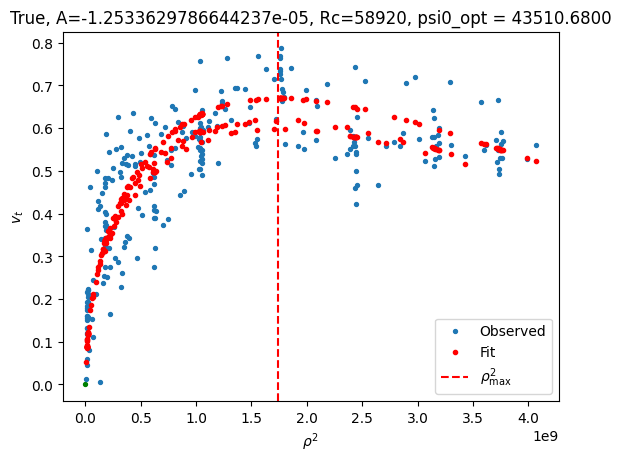

np.float64(58919.56126600725)

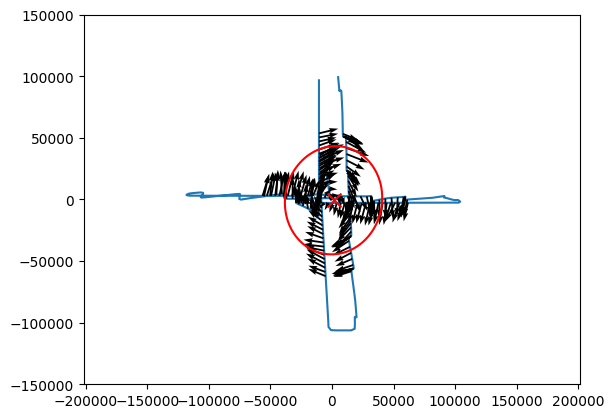

In [4]:
mask = np.hypot(df_sadcp.x-xc_0,  df_sadcp.y-yc_0) < 60000

xi, yi, ui, vi = df_sadcp[mask].x,  df_sadcp[mask].y, df_sadcp[mask].u_37, df_sadcp[mask].v_37

xc, yc, w, Q, Rc, psi0, A = espra(xi, yi, ui, vi, plot_flag=True, Rc_max=150000)

plt.plot(df_sadcp.x, df_sadcp.y)
plt.quiver(xi, yi, ui, vi, zorder=2)
plt.scatter(xc, yc, marker='x', s=100, color='r', zorder=3)

dx_ell, dy_ell = X - xc, Y - yc
rho2_ell = Q[0,0]*dx_ell**2 + 2*Q[1,0]*dx_ell*dy_ell + Q[1,1]*dy_ell**2
plt.contour(X, Y, rho2_ell, levels=[Rc**2/2],
            colors='r')

plt.axis('equal')
Rc

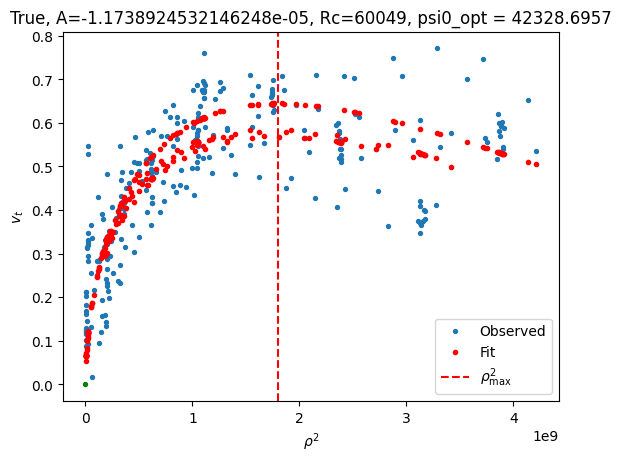

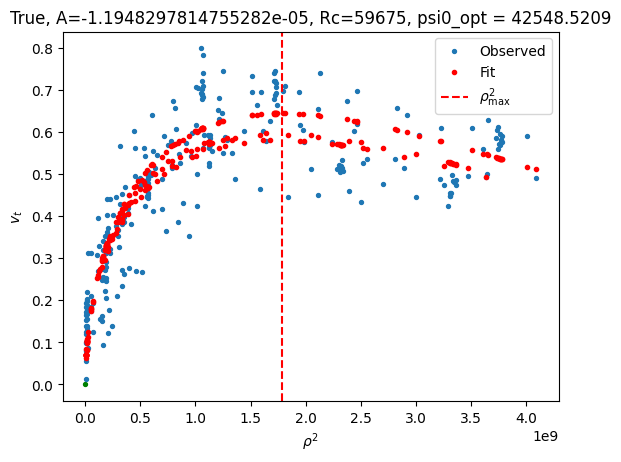

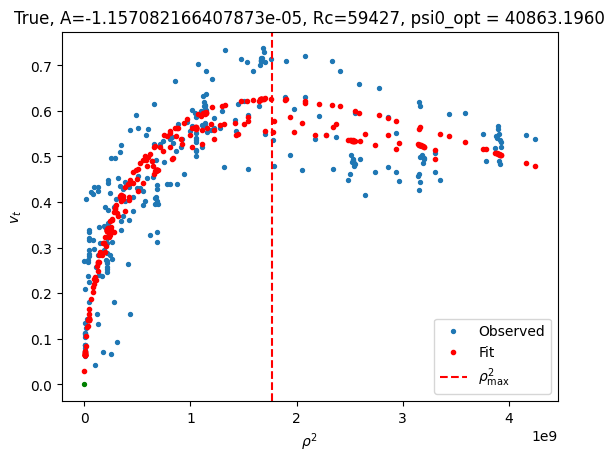

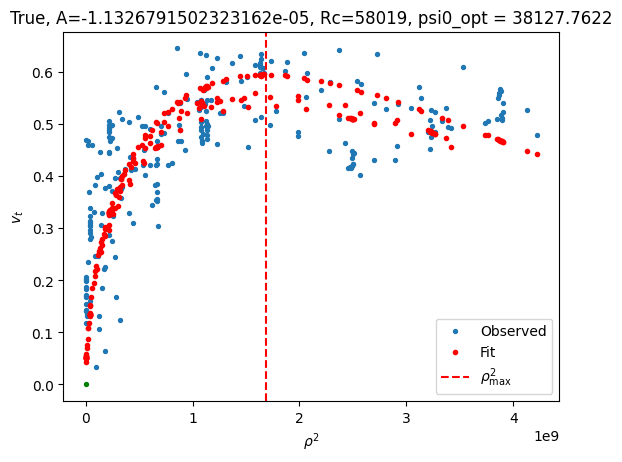

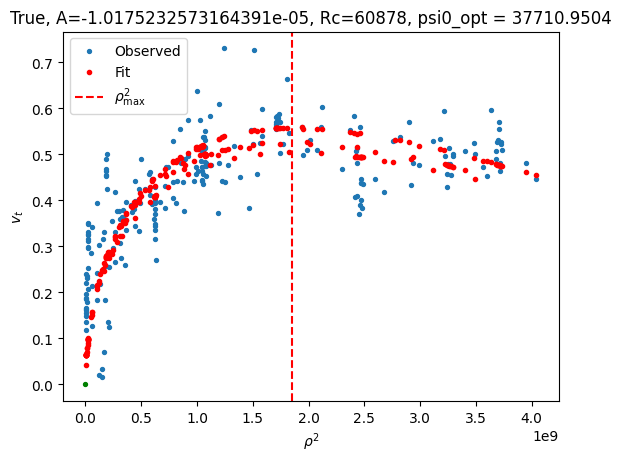

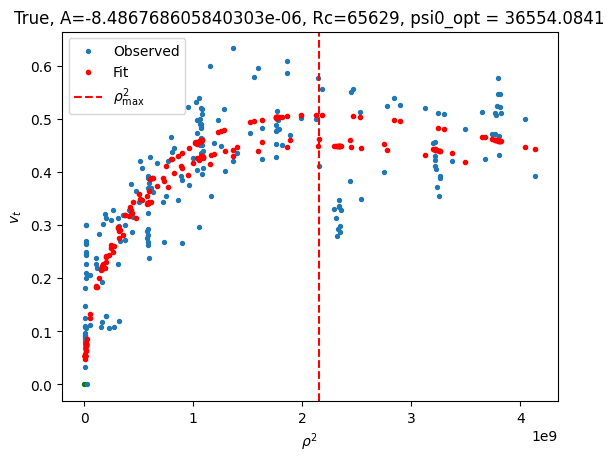

,xc,yc,w,Q,Rc,psi0,A,Depth
0,1286.208124,-624.748324,-0.000028,"[[1.1129700667896547, -0.04398819348292067], [...",58919.561266,43510.680046,-0.000013,37
1,1353.227920,-548.256624,-0.000027,"[[1.1127200735854694, -0.045913983397403914], ...",59829.413132,44021.764345,-0.000012,47
2,1726.233331,11.908230,-0.000027,"[[1.1152656400597005, -0.055414191497711214], ...",60594.299463,44308.704422,-0.000012,57
3,2182.707692,398.109130,-0.000027,"[[1.125877660351996, -0.06701915771283913], [-...",61973.003188,44694.292010,-0.000012,67
4,2534.142643,777.668048,-0.000026,"[[1.1412203115721602, -0.07342918506578708], [...",63479.606315,44932.520971,-0.000011,77
...,...,...,...,...,...,...,...,...
62,1437.841493,500.395037,-0.000020,"[[1.1062460094520332, -0.051302144705152604], ...",64654.895992,34892.154233,-0.000008,657
63,1759.895550,1390.427995,-0.000019,"[[1.1087769887120633, -0.06377797167581742], [...",64428.312380,34531.459910,-0.000008,667
64,2075.035713,1918.722596,-0.000019,"[[1.107885884763181, -0.06788187252043115], [-...",65333.626174,34578.512597,-0.000008,677
65,1470.142241,2297.330118,-0.000019,"[[1.104978064760999, -0.06881874413837882], [-...",65998.507689,34666.052104,-0.000008,687


In [9]:
df_core_sadcp = df_sadcp[np.hypot(df_sadcp.x-xc_0,df_sadcp.y-yc_0)<60000]
u_cols = [col for col in df_core_sadcp.columns if 'u' in col]
v_cols = [col for col in df_core_sadcp.columns if 'v' in col]

df_res = pd.DataFrame(columns=['xc', 'yc', 'w', 'Q', 'Rc', 'psi0', 'A', 'Depth'])
dic_depth = {}
for k, (u_col, v_col) in enumerate(zip(u_cols, v_cols)):
    xi, yi = df_core_sadcp.x, df_core_sadcp.y
    ui = df_core_sadcp[u_col]
    vi = df_core_sadcp[v_col]
    mask = ~np.isnan(xi) & ~np.isnan(yi) & ~np.isnan(ui) & ~np.isnan(vi)
    xi, yi, ui, vi = xi[mask], yi[mask], ui[mask], vi[mask]
    depth = int(u_col[2:])
    if (depth < 700) & (len(xi) > 2):
        xc, yc, w, Q, Rc, psi0, A = espra(xi, yi, ui, vi, plot_flag=True if k%10==0 else False, Rc_max=150000)
        df_res.loc[len(df_res)] = {'xc': xc, 'yc': yc, 'w': w, 'Q': Q, 'Rc': Rc, 'psi0': psi0, 'A': A, 'Depth': depth}
        dic_depth[f'Depth{depth}'] = {'xi': xi, 'yi': yi, 'ui': ui, 'vi': vi}
df_res


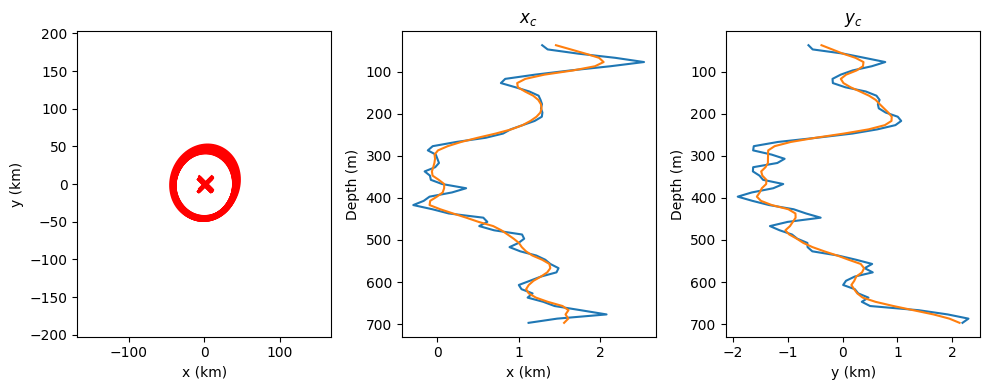

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(10,4))
for k in range(len(df_res)):
    data = df_res.iloc[k]
    axs[0].scatter(data.xc/1e3, data.yc/1e3, marker='x', s=100, color='r', zorder=3)
    dx_ell, dy_ell = X/1e3 - data.xc/1e3, Y/1e3 - data.yc/1e3
    rho2_ell = data.Q[0,0]*dx_ell**2 + 2*data.Q[1,0]*dx_ell*dy_ell + data.Q[1,1]*dy_ell**2
    axs[0].contour(X/1e3, Y/1e3, rho2_ell, levels=[(data.Rc/1e3)**2/2],
                colors='r')
axs[0].axis('equal'); axs[0].set_xlabel('x (km)'); axs[0].set_ylabel('y (km)')

wdw = 5
df_res['sxc'] = smooth(df_res.xc, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['syc'] = smooth(df_res.yc, df_res.Depth, window=wdw, num=len(df_res)) 
axs[1].plot(df_res.xc/1e3, df_res.Depth)
axs[1].plot(df_res.sxc/1e3, df_res.Depth)
axs[1].invert_yaxis()
axs[1].set_xlabel('x (km)'); axs[1].set_ylabel('Depth (m)'); axs[1].set_title(r'$x_c$')
axs[2].plot(df_res.yc/1e3, df_res.Depth)
axs[2].plot(df_res.syc/1e3, df_res.Depth)
axs[2].invert_yaxis()
axs[2].set_xlabel('y (km)'); axs[2].set_ylabel('Depth (m)'); axs[2].set_title(r'$y_c$')
plt.tight_layout()
                 

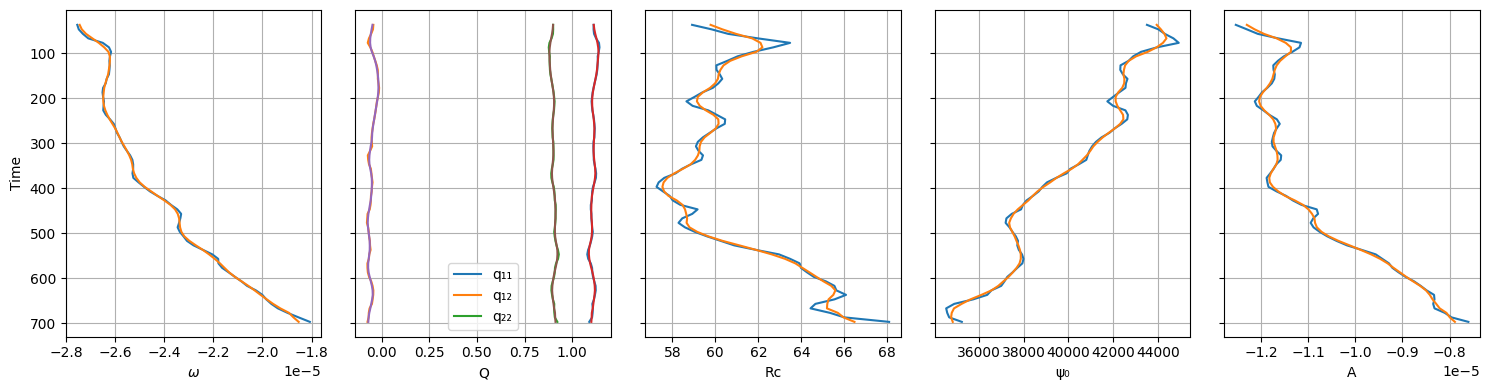

In [20]:
wdw = 5
df_res['sw'] = smooth(df_res.w, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq11'] = smooth(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq12'] = smooth(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sq22'] = smooth(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sRc'] = smooth(df_res.Rc, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['spsi0'] = smooth(df_res.psi0, df_res.Depth, window=wdw, num=len(df_res)) 
df_res['sA'] = smooth(df_res.A, df_res.Depth, window=wdw, num=len(df_res)) 

fig, axs = plt.subplots(1, 5, figsize=(15,4), sharey=True)

axs[0].plot(df_res.w, df_res.Depth)
axs[0].plot(df_res.sw, df_res.Depth)
axs[0].set_xlabel(r'$\omega$')

axs[1].plot(df_res.Q.apply(lambda Q: Q[0,0]), df_res.Depth, label='q₁₁')
axs[1].plot(df_res.Q.apply(lambda Q: Q[0,1]), df_res.Depth, label='q₁₂')
axs[1].plot(df_res.Q.apply(lambda Q: Q[1,1]), df_res.Depth, label='q₂₂')
axs[1].plot(df_res.sq11, df_res.Depth)
axs[1].plot(df_res.sq12, df_res.Depth)
axs[1].plot(df_res.sq22, df_res.Depth)
axs[1].set_xlabel('Q')
axs[1].legend()

axs[2].plot(df_res.Rc/1000, df_res.Depth)
axs[2].plot(df_res.sRc/1000, df_res.Depth)
axs[2].set_xlabel('Rc')

axs[3].plot(df_res.psi0, df_res.Depth)
axs[3].plot(df_res.spsi0, df_res.Depth)
axs[3].set_xlabel('ψ₀')

axs[4].plot(df_res.A, df_res.Depth)
axs[4].plot(df_res.sA, df_res.Depth)
axs[4].set_xlabel('A')

for ax in axs:
    ax.grid(True)
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()


In [22]:
U = np.zeros((X.shape[0], X.shape[1], len(df_res)))
V = np.zeros((X.shape[0], X.shape[1], len(df_res)))

for k in range(len(df_res)):
    data = df_res.iloc[k]
    dx, dy = X - data.sxc, Y - data.syc
    rho2 = data.sq11*dx**2 + 2*data.sq12*dx*dy + data.sq22*dy**2

    U[:,:,k] = - data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq12*dx + 2*data.sq22*dy )
    V[:,:,k] =   data.sA * np.exp( - rho2 / data.sRc**2 ) * ( 2*data.sq11*dx + 2*data.sq12*dy ) 
    

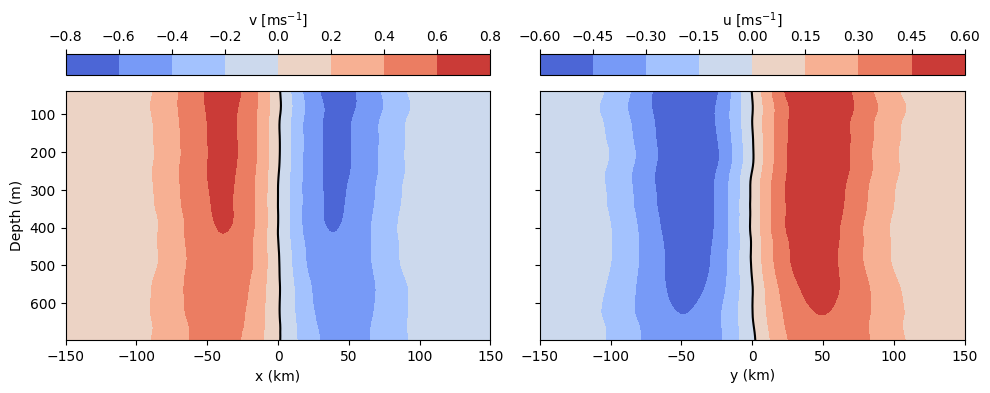

In [30]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 4))

xc_surf, yc_surf = df_res.iloc[0].xc, df_res.iloc[0].yc
ic_surf = np.argmin(np.abs(x - xc_surf))
jc_surf = np.argmin(np.abs(y - yc_surf))

c1 = axs[0].contourf(x/1e3, df_res.Depth, V[:, jc_surf, :].T, cmap='coolwarm')
axs[0].plot(df_res.sxc/1e3, df_res.Depth, color='k')
c2 = axs[1].contourf(y/1e3, df_res.Depth, U[ic_surf, :, :].T , cmap='coolwarm')
axs[1].plot(df_res.syc/1e3, df_res.Depth, color='k')
axs[0].invert_yaxis()

fig.colorbar(c1, ax=axs[0], orientation='horizontal', location='top', label=r'v [ms$^{-1}$]')
fig.colorbar(c2, ax=axs[1], orientation='horizontal', location='top', label=r'u [ms$^{-1}$]')

axs[0].set_ylabel('Depth (m)'); axs[0].set_xlabel('x (km)'); axs[1].set_xlabel('y (km)');
plt.tight_layout()
plt.show()


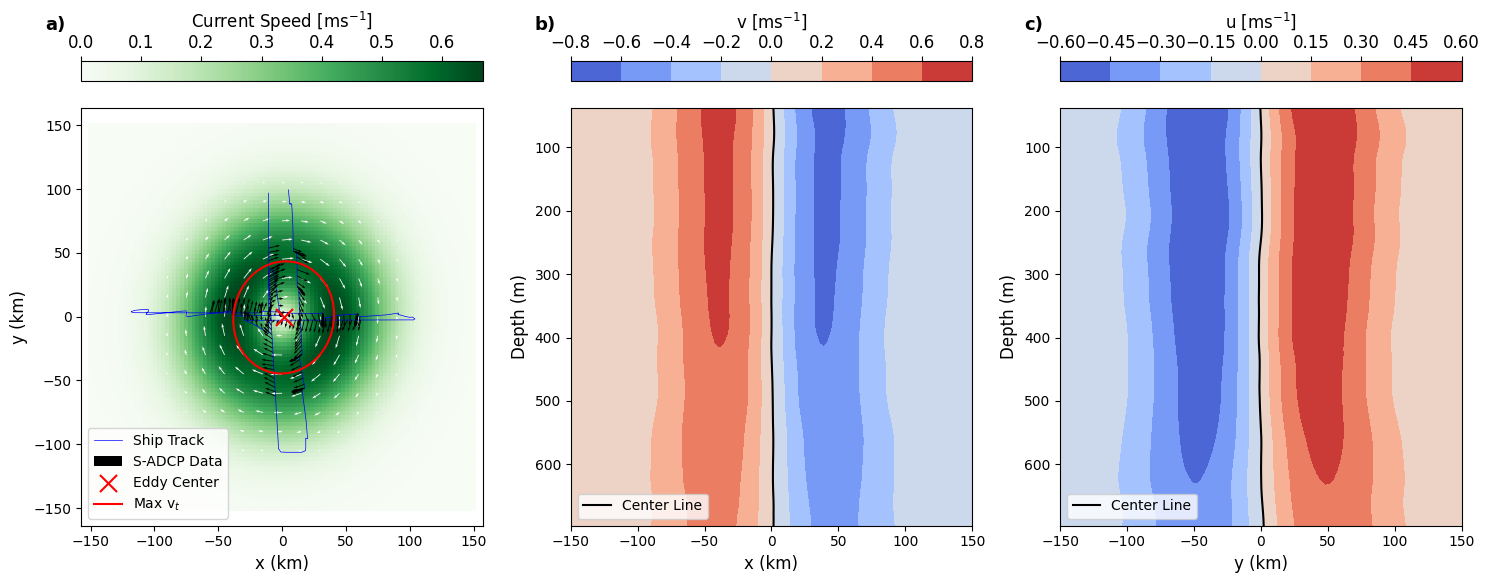

In [125]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
width, scale = .002, 20

# Plot 1
ax = axs[0]
pc = ax.pcolor(X/1e3, Y/1e3, np.hypot(U[:,:,0], V[:,:,0]), zorder=0, cmap='Greens', vmin=0)
cb = fig.colorbar(pc, ax=ax, location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'Current Speed [ms$^{-1}$]', fontsize=12)
spac = 5
ax.quiver(X[::spac,::spac]/1e3, Y[::spac,::spac]/1e3,
          U[::spac,::spac,0], V[::spac,::spac,0],
          color='w', width=width, scale=scale, zorder=0)
ax.plot(df_sadcp.x/1e3, df_sadcp.y/1e3, zorder=1, color='b', lw=.5, label='Ship Track')
ax.quiver(df_core_sadcp.x/1e3, df_core_sadcp.y/1e3, df_core_sadcp.u_37, df_core_sadcp.v_37,
          zorder=1, width=width, scale=scale, color='k', label='S-ADCP Data')
data = df_res.iloc[0]
ax.scatter(data.xc/1e3, data.yc/1e3, marker='x', s=150, color='r', zorder=2, label='Eddy Center')
dx_ell, dy_ell = X/1e3 - data.xc/1e3, Y/1e3 - data.yc/1e3
rho2_ell = data.Q[0,0]*dx_ell**2 + 2*data.Q[1,0]*dx_ell*dy_ell + data.Q[1,1]*dy_ell**2
ax.contour(X/1e3, Y/1e3, rho2_ell, levels=[(data.Rc/1e3)**2/2], colors='r', zorder=2)
ax.plot([], [], color='r', lw=1.5, label=r'Max v$_t$') 
ax.axis('equal'); ax.set_xlabel('x (km)', fontsize=12);
ax.set_ylabel('y (km)', fontsize=12); ax.legend(loc='lower left')

# Plot 2 and 3
xc_surf, yc_surf = df_res.iloc[0].xc, df_res.iloc[0].yc
ic_surf = np.argmin(np.abs(x - xc_surf))
jc_surf = np.argmin(np.abs(y - yc_surf))

c1 = axs[1].contourf(x/1e3, df_res.Depth, V[:, jc_surf, :].T, cmap='coolwarm')
axs[1].plot(df_res.sxc/1e3, df_res.Depth, color='k', label='Center Line')
c2 = axs[2].contourf(y/1e3, df_res.Depth, U[ic_surf, :, :].T , cmap='coolwarm')
axs[2].plot(df_res.syc/1e3, df_res.Depth, color='k', label='Center Line')
axs[1].invert_yaxis(); axs[2].invert_yaxis()
axs[1].legend(loc='lower left'); axs[2].legend(loc='lower left')

cb = fig.colorbar(c1, ax=axs[1], location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'v [ms$^{-1}$]', fontsize=12)
cb = fig.colorbar(c2, ax=axs[2], location='top')
cb.ax.tick_params(labelsize=12)
cb.set_label(label=r'u [ms$^{-1}$]', fontsize=12)

axs[1].set_ylabel('Depth (m)', fontsize=12); axs[2].set_ylabel('Depth (m)', fontsize=12); 
axs[1].set_xlabel('x (km)', fontsize=12); axs[2].set_xlabel('y (km)', fontsize=12)

ax.text(-0.09, 1.22, 'a)', transform=ax.transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
axs[1].text(-0.09, 1.22, 'b)', transform=axs[1].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')
axs[2].text(-0.09, 1.22, 'c)', transform=axs[2].transAxes, fontsize=13, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.show()


In [128]:
df_core_sadcp.Time.max() - df_core_sadcp.Time.min()


Timedelta('4 days 02:44:59.666642')